# 1. Background

Transportation policy-makers often face the challenge of choosing between various transportation scenarios. To do this, they need to understand the flow of origin and destination (OD) of people. King County has diverse land use, including urban areas like Seattle, small towns like Issaquah, and rural areas like Snoqualmie. With different land uses, the population demographics also vary. Therefore, understanding how demographics and land use affect travel patterns is crucial for urban planning and transportation infrastructure development.

This study aims to **analyze the correlations between travel patterns, demographics, and land use**. The study seeks to answer the following questions:

* What is the correlation between OD flows and demographics given similar land uses?
* How do land use and demographics affect the number of trips?
* Does the city provide a reasonable amount of transit to each census tract based on demographics and land use types?


# 2. Data
Our data came from three sources for King County in 2019.
1. Travel flow data from the *[Puget Sound Regional Council Household Travel Survey](https://www.psrc.org/our-work/household-travel-survey-program)*
   - Variables extracted: number of transit trips originating and ending in each census tract in King County
   - Workflow: created origin-destination matrix for census tracts in King County (sparsity issue), filtered data to only include transit trips
3. Land use data from *[General Land Use Final Dataset](https://geo.wa.gov/datasets/a0ddbd4e0e2141b3841a6a42ff5aff46_0/about)*
   - Variables extracted: largest land use of each census tract
   - Workflow: clipped land use data by census tract geometries to determine the land use with the largest area proportion
5. Demographic data from *[American Community Survey](https://www.census.gov/programs-surveys/acs)*
   - Variables extracted: various demographic data (race, income, immigration status, housing costs, mode to travel to work, etc.)
   - Workflow: identified variables of interest, queried from Census API

In [31]:
import geopandas as gpd
import pandas as pd
import numpy as np
import geopandas as gpd
import skmob
import matplotlib.pyplot as plt
import folium
import matplotlib.colors as colors
import statsmodels.api as sm
import seaborn as sns
import branca.colormap as cm
from branca.colormap import linear
# import ipympl

Load and Merge Data

In [2]:
# Census shapefiles
census_shp = gpd.read_file('./exported_data/psrc_census_tracts.geojson')

In [3]:
# Demographic
filename = "./exported_data/demographic_data"
file = open(filename)
demo_gdf = gpd.read_file(file)
demo_gdf = demo_gdf.set_index('Tract')

In [4]:
# OD
filename = "./exported_data/county_shp_transit.geojson"
file = open(filename)
od_gdf = gpd.read_file(file)
od_gdf = od_gdf.set_index(od_gdf['tractid'].astype('string').apply(lambda x: x[-6:]))
od_gdf.index.names = ['Tract']
od_gdf = od_gdf.drop(columns='geometry')

# OD data compatible with skmob
od_transit_flows = pd.read_csv('./exported_data/tract_flow_transit.csv')

In [5]:
# Landuse
filename = "./exported_data/tract_landuse_gdf"
file = open(filename)
landuse_gdf = gpd.read_file(file)
landuse_gdf = landuse_gdf.set_index('Tract')
landuse_gdf = landuse_gdf.drop(columns='geometry')

In [6]:
all_gdf = od_gdf.join(demo_gdf, how='left')

In [7]:
all_gdf = all_gdf.join(landuse_gdf)
all_gdf = all_gdf.reset_index()

# 3. Analysis & Discussion

# 3.1 Correlation matrix between demographic and OD flow

In [55]:
all_gdf_hm = all_gdf
all_gdf_hm.dtypes

Tract                             object
tractid                            int64
origin_flow                      float64
dest_flow                        float64
Name                              object
Density                          float64
% Race:WhiteAlone                float64
% Race:BlackAlone                float64
% Race:AsianAlone                float64
% Race:Other                     float64
% BelowPovertyLevel              float64
% Immigration                    float64
% Umemployment                   float64
% ToWork:Car                     float64
% ToWork:Transit                 float64
% ToWork:Bike                    float64
% ToWork:Walk                    float64
% ToWork:WFH                     float64
RatioMedianGrossRentToIncome     float64
RatioMedianHomeValueToIncome     float64
geometry                        geometry
land_use                          object
dtype: object

In [61]:
all_gdf_hm = all_gdf_hm.drop(columns=['geometry','Tract','tractid','Name','geometry'])
all_gdf_hm.head()

,origin_flow,dest_flow,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH,RatioMedianGrossRentToIncome,RatioMedianHomeValueToIncome,land_use
0,272.95695,272.95695,1730.720957,52.318286,14.521806,14.322877,18.837031,9.854629,18.944147,2.876817,52.639633,5.554705,0.000000,0.336649,1.438409,0.022329,5.293762,Urban Character Residential
1,0.00000,0.00000,1239.464041,62.771662,8.947220,18.204911,10.076207,3.810330,4.826418,2.681343,48.461756,3.415185,0.000000,0.310471,3.358736,0.017208,3.646323,Other
2,0.00000,0.00000,1492.774647,59.607732,6.310404,12.734508,21.347356,7.561114,9.238204,1.705514,44.030699,2.046617,0.000000,0.255827,2.956225,0.020622,3.848660,Urban Character Residential
4,0.00000,0.00000,1968.115919,21.297284,25.056326,37.578560,16.067829,14.704139,18.024428,1.138385,41.088581,9.107079,0.166014,0.154156,1.921025,0.025035,6.767804,Intensive Urban
5,0.00000,0.00000,3494.566362,27.519488,16.745546,7.196548,48.538419,21.520045,24.123051,3.800111,38.780624,4.565702,0.236637,0.570713,5.470490,0.021354,5.899225,Urban Character Residential


In [62]:
# fill na with 0
all_gdf_hm.fillna({'origin_flow': 0}, inplace=True)
all_gdf_hm.fillna({'dest_flow': 0}, inplace=True)

# drop the unclassified land use
all_gdf_hm = all_gdf_hm[all_gdf_hm['land_use'] != 'N/A']
all_gdf_hm = all_gdf_hm[all_gdf_hm['land_use'] != 'Undesignated']
all_gdf_hm.shape[0]

367

In [63]:
# check distribution
all_gdf_hm['land_use'].value_counts()

land_use
Urban Character Residential    218
Intensive Urban                106
Other                           22
Industrial                      21
Name: count, dtype: int64

In [64]:
# combined into 'Others'
all_gdf_hm.loc[all_gdf_hm['land_use'].isin(['Rural Character Residential', 'Active Open Space and Recreation', 
                                            'Natural Preservation and Conservation', 'Public']), 'land_use'] = 'Other'
all_gdf_hm['land_use'].value_counts()

land_use
Urban Character Residential    218
Intensive Urban                106
Other                           22
Industrial                      21
Name: count, dtype: int64

In [65]:
# List of unique land use types
land_use_types = all_gdf_hm['land_use'].unique()

# Dictionary to store correlation matrices for each land use type
correlation_matrices = {}

# Calculate correlation matrix for each land use type
for land_use in land_use_types:
    # Filter data for the current land use type
    land_use_data = all_gdf_hm[all_gdf_hm['land_use'] == land_use]
    
    # Calculate correlation matrix for origin_flow and dest_flow
    correlation_matrix = land_use_data.corr()
    
    # Store the correlation matrix in the dictionary
    correlation_matrices[land_use] = correlation_matrix

# Print correlation matrices for each land use type
for land_use, correlation_matrix in correlation_matrices.items():
    print(f"Correlation matrix for {land_use}:")
    print(correlation_matrix)
    print()

ValueError: could not convert string to float: 'Urban Character Residential'

In [23]:
all_gdf_hm.head()

,Tract,tractid,origin_flow,dest_flow,Name,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,...,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH,RatioMedianGrossRentToIncome,RatioMedianHomeValueToIncome,geometry,land_use
0,025701,53033025701,272.956950,272.956950,"Census Tract 257.01, King County, Washington",1730.720957,52.318286,14.521806,14.322877,18.837031,...,2.876817,52.639633,5.554705,0.000000,0.336649,1.438409,0.022329,5.293762,"POLYGON ((-122.20643 47.46969, -122.20642 47.4...",Urban Character Residential
9,029203,53033029203,12.128024,9.587235,"Census Tract 292.03, King County, Washington",2133.901618,49.486461,9.570495,7.913165,33.029879,...,0.653595,28.548086,5.859010,0.000000,1.377218,0.210084,0.021157,5.491599,"POLYGON ((-122.24444 47.38472, -122.24438 47.3...",Intensive Urban
12,032800,53033032800,2.535609,0.000000,"Census Tract 328, King County, Washington",1.804358,96.636684,0.351975,0.625733,2.385608,...,1.994525,48.572546,0.743058,0.273758,0.625733,4.732108,0.011854,5.053616,"POLYGON ((-121.84495 47.55041, -121.84452 47.5...",Active Open Space and Recreation
13,026300,53033026300,6.767908,0.000000,"Census Tract 263, King County, Washington",303.738455,26.700252,2.141058,41.687657,29.471033,...,6.045340,39.798489,4.471033,0.377834,0.314861,0.000000,0.020924,5.068951,"POLYGON ((-122.31845 47.53177, -122.31826 47.5...",Industrial
14,026400,53033026400,1505.419874,1505.419874,"Census Tract 264, King County, Washington",1176.205076,44.571237,12.065783,12.099346,31.263635,...,4.111428,48.363819,7.098506,0.000000,0.302064,1.980198,0.022600,5.425688,"POLYGON ((-122.33150 47.52096, -122.33102 47.5...",Urban Character Residential


# 3.2 OLS

Linear regression is a statistical technique used to describe relationships among variables. It can predict the relationship between variables by assuming a linear connection between the one or several independent variables (x) and dependent variable (y). The formula is given as:

Y = $B_0$ + $B_1$$X_1$ + $B_1$$X_2$ + ... + $B_p$$X_p$ + $\epsilon$

Where 
* Y = the dependent or predicted variable
* $B_0$ = the y-intercept
* $B_1$ and $B_2$ = regression coefficients representing the change in y relative to a one-unit change in $X_1$ and $X_2$, respectively
* $B_p$ = the slope coefficient for each independent variable
* $\epsilon$ = the model’s random error (residual) term

This study uses regression analysis to answer the following questions
1) Does race relate with trip number?
2) What type of land use has impact to the number of trip origin and trip destination?
3) Which factor effect number of the trip more: unemployment or poverty level?
4) What type of land use has higher number of transit to work use? what about WFH?

## 3.2.0 Clean data
Remove rows with NaN value and land use data that is 'N/A' type or 'Undesignated' type

In [55]:
all_gdf_lr = all_gdf.dropna()
all_gdf_lr = all_gdf_lr[all_gdf_lr['land_use'] != 'N/A']
all_gdf_lr = all_gdf_lr[all_gdf_lr['land_use'] != 'Undesignated']

Inspecting land use type data distribution 

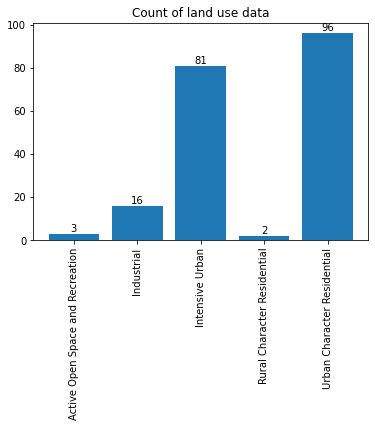

In [56]:
grouped_data = all_gdf_lr.groupby(['land_use'])['land_use'].count()
land_use_categories = grouped_data.index
heights = grouped_data.values
plt.bar(land_use_categories, heights)
plt.xticks(rotation='vertical');
plt.title('Count of land use data');

for i, value in enumerate(heights):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

To handle imbalance data, "Active Open Space and Recreation" and "Rural Character Residential" are excluded from the analysis as these data are too small. "Intensive Urban" and "Industrial" are combind and definded as "Mixed Urban" area type.

In [57]:
"""
all_gdf['land_use'] = all_gdf['land_use'].replace({
    'Intensive Urban': 'Mixed Urban',
    'Industrial': 'Mixed Urban'
})
all_gdf = all_gdf[~all_gdf['land_use'].isin(['Active Open Space and Recreation', 'Rural Character Residential'])]
"""

"\nall_gdf['land_use'] = all_gdf['land_use'].replace({\n    'Intensive Urban': 'Mixed Urban',\n    'Industrial': 'Mixed Urban'\n})\nall_gdf = all_gdf[~all_gdf['land_use'].isin(['Active Open Space and Recreation', 'Rural Character Residential'])]\n"

## 3.2.1 Race VS Trip Number

The dependent variable is the sum of original flow and destination flow. The independent variables are percentage of each race in each census

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


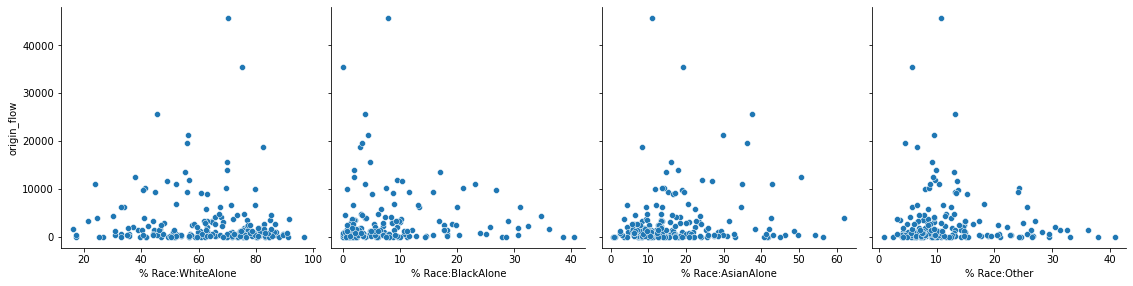

In [60]:
# Observe Data
sns.pairplot(all_gdf_lr, x_vars=['% Race:WhiteAlone','% Race:BlackAlone','% Race:AsianAlone','% Race:Other'], y_vars = 'origin_flow', size = 4, kind = 'scatter' )
plt.show()

In [61]:
X = all_gdf_lr[['% Race:WhiteAlone','% Race:BlackAlone','% Race:AsianAlone','% Race:Other']]

In [62]:
y = all_gdf_lr['origin_flow']+all_gdf_lr['dest_flow']

In [63]:
# fit linear regression model
model = sm.OLS(y, X).fit()

# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.539
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.206
Time:                        12:06:31   Log-Likelihood:                -2118.7
No. Observations:                 198   AIC:                             4245.
Df Residuals:                     194   BIC:                             4258.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
% Race:WhiteAlone    49.7496     19.213      2.589      0.010      11.856      87.644
% Race:BlackAlone   141.2025     99.646      1.417      0.158     -55.326     337.731
% Race:AsianAlone   147.1504     56.369      2.610      0.010      35.976     258.325
% Race:Other        -80.6080    101.507     -0.794      0.428    -280.807     119.591
==============================================================================
Omnibus:                      198.933   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4251.077
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      24.262   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color:blue"> A positive coefficient indicates that as the predictor variable increases, the Target variable also increases. From the result, as percentage of one race in census increase, the number of total trip also increase. Census with most majority is Asian trend to produce trip the most</span>

Plots below show relationship of race dominant and number of trip origin

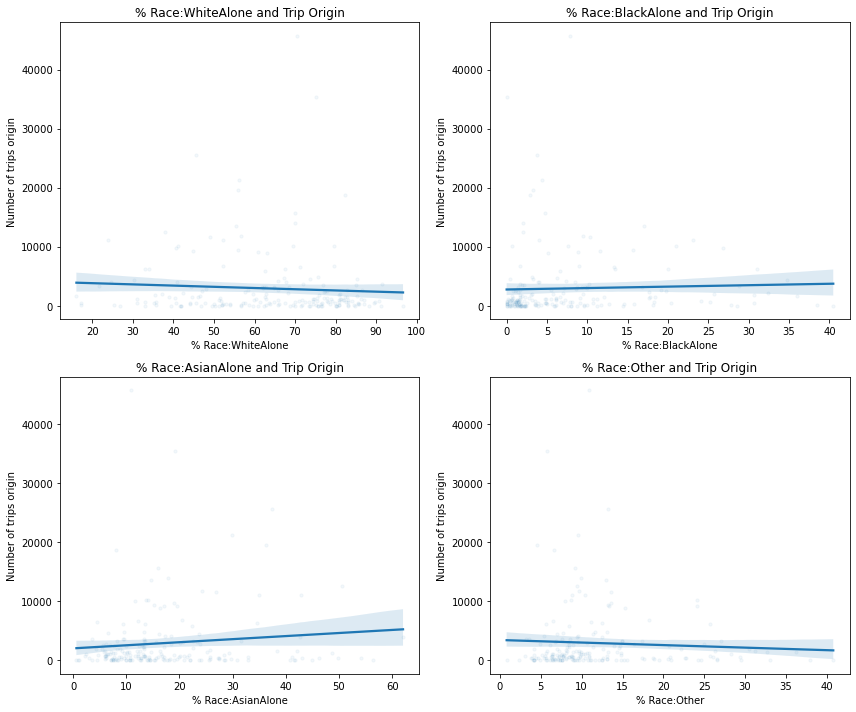

In [65]:
x_val = ['% Race:WhiteAlone','% Race:BlackAlone','% Race:AsianAlone','% Race:Other']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, item in enumerate(x_val):
    row = i // 2
    col = i % 2
    sns.regplot(x=item, y='origin_flow', data=all_gdf_lr, scatter_kws={"alpha": 0.05, "s": 10}, ax=axes[row, col])
    axes[row, col].set_title(f'{item} and Trip Origin')
    axes[row, col].set_xlabel(item)
    axes[row, col].set_ylabel('Number of trips origin')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## 3.2.2 Trip Number vs Land Use Type

This analysis use original flow and destination flow as dependent value. The independent variables are land use type (categorical value)

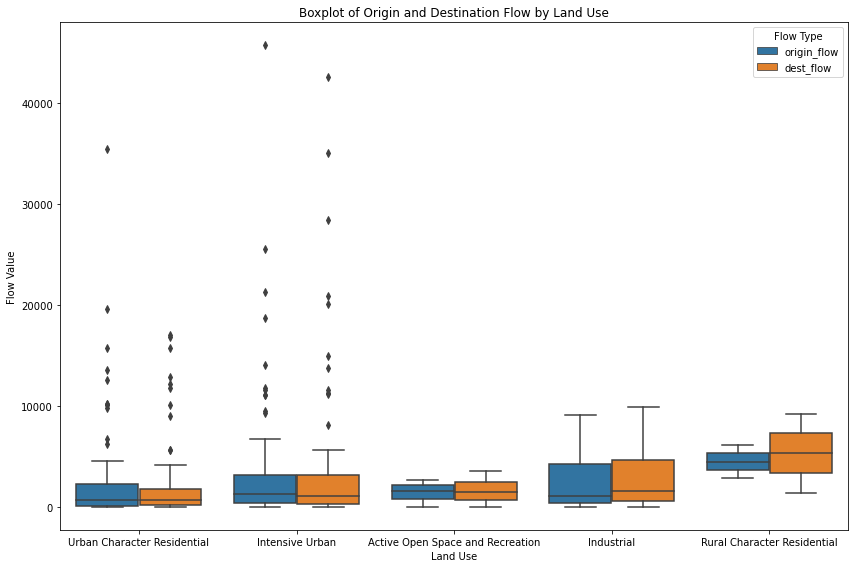

In [66]:
import seaborn as sns
df_long = pd.melt(all_gdf_lr, id_vars='land_use', value_vars=['origin_flow', 'dest_flow'], var_name='Flow Type', value_name='Flow Value')

plt.figure(figsize=(12, 8))
sns.boxplot(x='land_use', y='Flow Value', hue='Flow Type', data=df_long)

plt.title('Boxplot of Origin and Destination Flow by Land Use')
plt.xlabel('Land Use')
plt.ylabel('Flow Value')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [67]:
X = all_gdf_lr[['land_use']]
y = all_gdf_lr['origin_flow']+all_gdf_lr['dest_flow']

X = pd.get_dummies(data=X, drop_first=True)
X.head()

,land_use_Industrial,land_use_Intensive Urban,land_use_Rural Character Residential,land_use_Urban Character Residential
0,0,0,0,1
9,0,1,0,0
12,0,0,0,0
13,1,0,0,0
14,0,0,0,1


In [68]:
# fit linear regression model
model = sm.OLS(y, X).fit()

# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.236
Model:                            OLS   Adj. R-squared (uncentered):              0.220
Method:                 Least Squares   F-statistic:                              14.94
Date:                Mon, 04 Mar 2024   Prob (F-statistic):                    1.16e-10
Time:                        12:06:53   Log-Likelihood:                         -2119.2
No. Observations:                 198   AIC:                                      4246.
Df Residuals:                     194   BIC:                                      4260.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
land_use_Industrial                   5250.1097   2718.834      1.931      0.055    -112.158    1.06e+04
land_use_Intensive Urban              7460.4255   1208.371      6.174      0.000    5077.196    9843.655
land_use_Rural Character Residential  9779.1678   7690.023      1.272      0.205   -5387.615    2.49e+04
land_use_Urban Character Residential  4481.7169   1109.959      4.038      0.000    2292.580    6670.853
==============================================================================
Omnibus:                      191.464   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3517.431
Skew:                           3.816   Prob(JB):                         0.00
Kurtosis:                      22.186   Cond. No.                         6.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color:blue"> Box plot shows that 'Intensive urban resident' and 'Urban Characteristic Resident' has wide range of the number of trip, however, most of data are outliner which indicated that there are some special area where there are trip generated more than usual. From regression analysis, it can indicate that rural residential area are likely to generate amouth of trips. This make sense as facilities might be limited in rural area so people need to make trip to do their activities  </span>

## 3.2.3 Which factor effect number of the trip more: unemployment or poverty level?

This analysis use original flow and destination flow as dependent value. The independent variables are percentage of unemployment population and percentage of population with BelowPovertyLevel

Text(0.5, 1.0, '% Unemployment vs % BelowPovertyLevel')

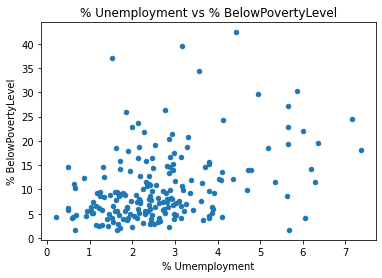

In [69]:
# Inspect the relation of unemployment and poverty level
all_gdf_lr.plot.scatter(x='% Umemployment',y='% BelowPovertyLevel')
plt.title('% Unemployment vs % BelowPovertyLevel')

In [70]:
X = all_gdf_lr[['% Umemployment','% BelowPovertyLevel']]
y = all_gdf_lr['origin_flow']+all_gdf_lr['dest_flow']

In [71]:
# fit linear regression model
model = sm.OLS(y, X).fit()

# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.234
Model:                            OLS   Adj. R-squared (uncentered):              0.226
Method:                 Least Squares   F-statistic:                              29.89
Date:                Mon, 04 Mar 2024   Prob (F-statistic):                    4.69e-12
Time:                        12:07:05   Log-Likelihood:                         -2119.4
No. Observations:                 198   AIC:                                      4243.
Df Residuals:                     196   BIC:                                      4249.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
% Umemployment        894.5723    461.404      1.939      0.054     -15.381    1804.526
% BelowPovertyLevel   282.8231    108.976      2.595      0.010      67.907     497.739
==============================================================================
Omnibus:                      190.443   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3486.356
Skew:                           3.785   Prob(JB):                         0.00
Kurtosis:                      22.112   Cond. No.                         7.84
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

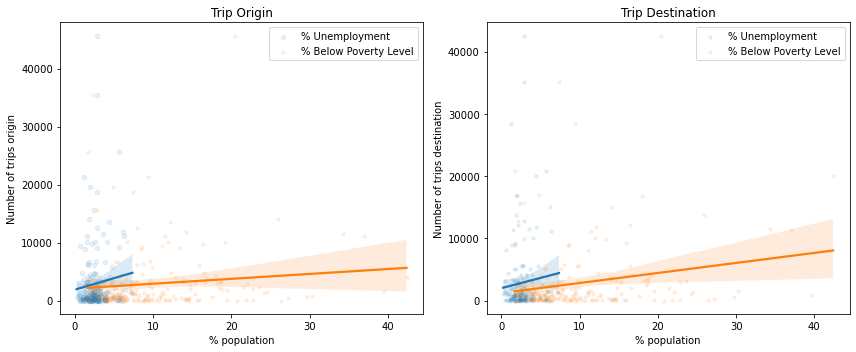

In [72]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot for 'Trip Origin'
sns.regplot(x='% Umemployment', y='origin_flow', data=all_gdf_lr, scatter_kws={"alpha": 0.1, "s": 20}, ax=axes[0], label='% Unemployment')
sns.regplot(x='% BelowPovertyLevel', y='origin_flow', data=all_gdf_lr, scatter_kws={"alpha": 0.1, "s": 10}, ax=axes[0], label='% Below Poverty Level')
axes[0].set_title('Trip Origin')
axes[0].set_xlabel('% population')
axes[0].set_ylabel('Number of trips origin')

# Regression plot for 'Trip Destination'
sns.regplot(x='% Umemployment', y='dest_flow', data=all_gdf_lr, scatter_kws={"alpha": 0.1, "s": 10}, ax=axes[1], label='% Unemployment')
sns.regplot(x='% BelowPovertyLevel', y='dest_flow', data=all_gdf_lr, scatter_kws={"alpha": 0.1, "s": 10}, ax=axes[1], label='% Below Poverty Level')
axes[1].set_title('Trip Destination')
axes[1].set_xlabel('% population')
axes[1].set_ylabel('Number of trips destination')

axes[0].legend()
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<span style="color:blue"> From scatter plot, percentage of unemployment and population with below poverty level are related. However, these two factor has different effect to the number of trip. From linear regression analysis, area with higher unemployment makes more trip than area with people below poverty level. This can be concluded that people below poverty cannot affroad travel expense than unemployememt people</span>

## 3.2.4 What type of land use has higher number of transit to work use? what about WFH?

This analysis use percentage of people who use transit to work or percentage of people who work from home (WFH) as dependent value. The independent variables are land use type (categorial)

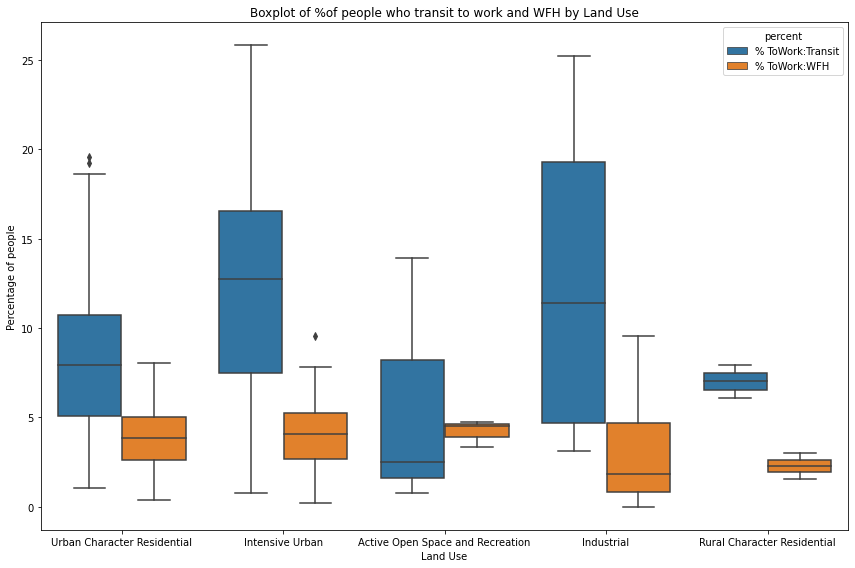

In [73]:
import seaborn as sns
df_long = pd.melt(all_gdf_lr, id_vars='land_use', value_vars=['% ToWork:Transit', '% ToWork:WFH'], var_name='percent', value_name='% of people')

plt.figure(figsize=(12, 8))
sns.boxplot(x='land_use', y='% of people', hue='percent', data=df_long)

plt.title('Boxplot of %of people who transit to work and WFH by Land Use')
plt.xlabel('Land Use')
plt.ylabel('Percentage of people')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [74]:
# Transit to work
X = all_gdf_lr[['land_use']]
y = all_gdf_lr['% ToWork:Transit']

X = pd.get_dummies(data=X, drop_first=True)

In [75]:
# fit linear regression model
model = sm.OLS(y, X).fit()

# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       % ToWork:Transit   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.788
Method:                 Least Squares   F-statistic:                              184.6
Date:                Mon, 04 Mar 2024   Prob (F-statistic):                    5.77e-65
Time:                        12:07:23   Log-Likelihood:                         -611.87
No. Observations:                 198   AIC:                                      1232.
Df Residuals:                     194   BIC:                                      1245.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
land_use_Industrial                     12.0806      1.343      8.992      0.000       9.431      14.730
land_use_Intensive Urban                12.2899      0.597     20.583      0.000      11.112      13.468
land_use_Rural Character Residential     7.0098      3.800      1.845      0.067      -0.484      14.504
land_use_Urban Character Residential     8.3243      0.548     15.178      0.000       7.243       9.406
==============================================================================
Omnibus:                        4.138   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                4.141
Skew:                           0.320   Prob(JB):                        0.126
Kurtosis:                       2.694   Cond. No.                         6.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# WFH
X = all_gdf_lr[['land_use']]
y = all_gdf_lr['% ToWork:WFH']

X = pd.get_dummies(data=X, drop_first=True)

In [77]:
# fit linear regression model
model = sm.OLS(y, X).fit()

# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           % ToWork:WFH   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              192.8
Date:                Mon, 04 Mar 2024   Prob (F-statistic):                    2.04e-66
Time:                        12:07:27   Log-Likelihood:                         -411.41
No. Observations:                 198   AIC:                                      830.8
Df Residuals:                     194   BIC:                                      844.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
land_use_Industrial                      2.8205      0.488      5.778      0.000       1.858       3.783
land_use_Intensive Urban                 4.0694      0.217     18.758      0.000       3.642       4.497
land_use_Rural Character Residential     2.2782      1.381      1.650      0.101      -0.445       5.001
land_use_Urban Character Residential     3.9001      0.199     19.572      0.000       3.507       4.293
==============================================================================
Omnibus:                        7.055   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.978
Skew:                           0.457   Prob(JB):                       0.0305
Kurtosis:                       3.096   Cond. No.                         6.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<span style="color:blue"> Percentage of people who WFH is lower than people who transit to work in every land use type. People mostly use transit to work in Industrial and Intencive Urban area. As these area mostly have good transit facility and mainly serving for people who working. However, people who live in intenseive urban area tend to WFH the most. This indicated that intensive urban area must have both office and residential area. </span>

# 3.3 Interactive Graph 
- Relationship between OD flows and demographic/land use
- Relationship between land use and demographics (how to plot this one?)

- can't get land use to properly plot in folium. so will just have some static maps

In [25]:
all_gdf = gpd.GeoDataFrame(all_gdf)

In [26]:
# create tesselation for skmob
tessellation = all_gdf.reset_index().rename(columns={'tractid':'tile_ID'})

In [32]:
m = folium.Map(location=(47.5480, -121.9836), tiles=None, zoom_start=10)

'''
names = ['Density','% Race:WhiteAlone', '% Race:BlackAlone', '% Race:AsianAlone',
       '% Race:Other', '% BelowPovertyLevel', '% Immigration',
       '% Umemployment', '% ToWork:Car', '% ToWork:Transit', '% ToWork:Bike',
       '% ToWork:Walk', '% ToWork:WFH', 'RatioMedianGrossRentToIncome',
       'RatioMedianHomeValueToIncome']
'''
names = ['Density','% Race:BlackAlone', 
       '% BelowPovertyLevel', '% Umemployment', '% ToWork:Transit', '% ToWork:WFH']

# plot each function with a radio button to toggle on/off
for nm in names:
    fg = folium.FeatureGroup(name=nm, overlay = False).add_to(m)
    choro = folium.Choropleth(geo_data=all_gdf,
        data=all_gdf,
        columns=["Tract", nm],
        key_on="feature.properties.Tract",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=nm,
        name=nm).geojson.add_to(fg)
    
#     gjson = folium.GeoJson(data=all_gdf, 
#                            tooltip=folium.GeoJsonTooltip(fields=[nm],
#                                                         labels=False,
#                                                         sticky=True)).add_to(choro)

# plot OD flows
fdf = skmob.FlowDataFrame(od_transit_flows, tessellation=tessellation, tile_id='tile_ID', 
                          origin='origin', destination='destination', flow='flow')
fdf.plot_flows(min_flow=1, flow_weight=0.05, flow_exp=0.9, flow_color='red', opacity=0.4, 
               tile_popup=False,map_f=m)
# set colormap
colormap = linear.YlGn_09.scale(0, 1).to_step(10)
colormap.caption = "Percent"
colormap.add_to(m)

folium.TileLayer('OpenStreetMap', overlay=True).add_to(m)
folium.LayerControl().add_to(m)
display(m)

AttributeError: module 'skmob' has no attribute 'FlowDataFrame'

## Create static land use plots

In [16]:
# combine N/A and Undesignated into one category
all_gdf['land_use'] = all_gdf['land_use'].replace({
    'N/A': 'Unknown',
    'Undesignated': 'Unknown'
})

In [22]:
# %matplotlib widget
%matplotlib inline

/tmp/ipykernel_274/86644626.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_flows_gdf = all_gdf.set_geometry(all_gdf.geometry.centroid)
/tmp/ipykernel_274/86644626.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_flows_gdf = all_gdf.set_geometry(all_gdf.geometry.centroid)
/tmp/ipykernel_274/86644626.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_flows_gdf = all_gdf.set_geometry(all_gdf.geometry.centroid)
/tmp/ipykernel_274/86644626.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. 

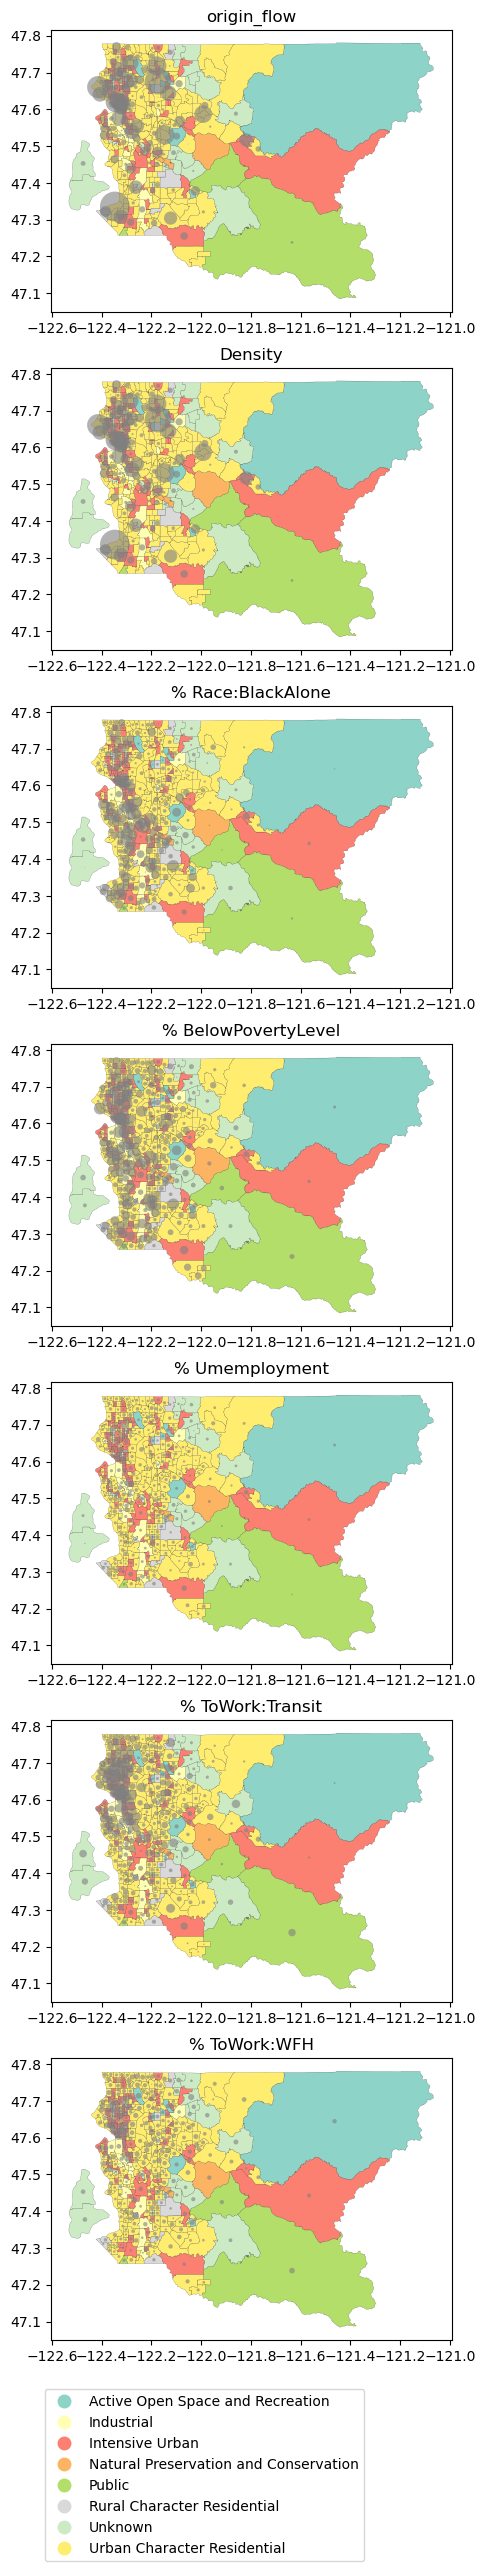

In [24]:
# bubble plots for demographics, OD flows in each census tract
vars = ['origin_flow', 'Density','% Race:BlackAlone', 
       '% BelowPovertyLevel', '% Umemployment', '% ToWork:Transit', '% ToWork:WFH']
f, ax = plt.subplots(7, figsize=(10, 30))
for i in range(len(vars)):
       # land use map
       if i == 6:
              all_gdf.plot(column='land_use', categorical=True, legend=True, linewidth=0.1, ax=ax[i], edgecolor='black', cmap='Set3')
       else:
              all_gdf.plot(column='land_use', categorical=True, legend=False, linewidth=0.1, ax=ax[i], edgecolor='black', cmap='Set3')

       # bubble plot overlay
       centroid_flows_gdf = all_gdf.set_geometry(all_gdf.geometry.centroid) 
       if i < 2:
              centroid_flows_gdf.plot(ax=ax[i], facecolor='gray', linewidth=0.05, legend=True, markersize=centroid_flows_gdf['origin_flow']/100, alpha=0.6)
       else:
              centroid_flows_gdf.plot(ax=ax[i], facecolor='gray', linewidth=0.05, legend=True, markersize=centroid_flows_gdf[vars[i]]*2, alpha=0.6)
       ax[i].set_title(vars[i])

# one legend for all plots
ax[6].get_legend().set_bbox_to_anchor((0.8, -0.15))






# 4. Conclusion